# Demonstration: using python for working with World Bank Data: plotting and data insertion

## Loading dependencies of the notebook

We use `pandas` to handle regular tabular data, `numpy` for numerical functionality, `wbgapi` to interact with World Bank Open Data's API and `geopandas` to handle geographical mapping.

In [1]:
! bash -i -l -c "pip install wbgapi pycountry && conda install -q -y descartes geopandas ffmpeg"


# All requested packages already installed.



In [2]:
import wbgapi as wb
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

## Exploring data on using `wbgapi`

`wbgapi` is a wrapper library for the World Bank Web API. For an introduction, please refer to the [vignette](https://blogs.worldbank.org/opendata/introducing-wbgapi-new-python-package-accessing-world-bank-data) of the package.

In [3]:
FDI_GDP_PCT_info = wb.series.metadata.get('BX.KLT.DINV.WD.GD.ZS')

In [4]:
FDI_GDP_PCT_info

Field,Value
Aggregationmethod,Weighted Average
Developmentrelevance,"Private financial flows - equity and debt - account for the bulk of development finance. Equity flows comprise foreign direct investment (FDI) and portfolio equity. Debt flows are financing raised through bond issuance, bank lending, and supplier credits."
Generalcomments,Note: Data starting from 2005 are based on the sixth edition of the IMF's Balance of Payments Manual (BPM6).
IndicatorName,"Foreign direct investment, net inflows (% of GDP)"
License_Type,CC BY-4.0
License_URL,https://datacatalog.worldbank.org/public-licenses#cc-by
Limitationsandexceptions,"FDI data do not give a complete picture of international investment in an economy. Balance of payments data on FDI do not include capital raised locally, an important source of investment financing in some developing countries. In addition, FDI data omit nonequity cross-border transactions such as intra-unit flows of goods and services. The volume of global private financial flows reported by the World Bank generally differs from that reported by other sources because of differences in sources, classification of economies, and method used to adjust and disaggregate reported information. In addition, particularly for debt financing, differences may also reflect how some installments of the transactions and certain offshore issuances are treated. Data on equity flows are shown for all countries for which data are available."
Longdefinition,"Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows net inflows (new investment inflows less disinvestment) in the reporting economy from foreign investors, and is divided by GDP."
Periodicity,Annual
Source,"International Monetary Fund, International Financial Statistics and Balance of Payments databases, World Bank, International Debt Statistics, and World Bank and OECD GDP estimates."


In [5]:
FDI_GDP_PCT_data = wb.data.DataFrame('BX.KLT.DINV.WD.GD.ZS', time=range(2000, 2020,), labels=True)
FDI_GDP_PCT_data.reset_index(inplace = True)

## Plotting the data

The plot we produce is quite similar to the one available directly on the website of the World Bank (see [source](https://data.worldbank.org/indicator/BX.KLT.DINV.CD.WD?view=map&year=2001)). 

In [6]:
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

It is possible to use `pandas` merge to merge a `geopandas` data frame with a regular `pandas` DataFrame. Once the appropriate cleanup and transformation is done, we call the `GeoDataFrame` constructor that uses the `geometry` column of `data_mapped` to as the geometry field.

In [7]:
data_mapped = pd.merge(FDI_GDP_PCT_data, worldmap, left_on = 'economy', right_on = 'iso_a3')
data_mapped.drop(['pop_est', 'economy', 'gdp_md_est', 'Country'], axis = 1, inplace = True)
data_mapped = data_mapped.melt(id_vars = ['continent', 'iso_a3', 'name', 'geometry'])
data_mapped = gpd.GeoDataFrame(data_mapped)

In [8]:
FDI_GDP_PCT_data

,economy,Country,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
0,ZWE,Zimbabwe,0.346788,0.056069,0.408381,0.066346,0.149855,1.786206,0.734768,1.301978,...,1.018022,2.441511,2.044131,1.954060,2.425173,1.999687,1.669274,1.121496,3.062893,1.305924
1,ZMB,Zambia,3.379914,3.541352,7.114949,7.078975,5.851719,4.284032,4.827129,9.418112,...,8.533196,4.725162,6.789381,7.487105,5.553442,7.450178,3.163072,4.281401,1.552281,2.350807
2,YEM,"Yemen, Rep.",0.066299,1.573189,1.068780,-0.756557,1.034961,-1.803717,5.880659,4.236847,...,0.610358,-1.582339,-0.040222,-0.330496,-0.539513,-0.036383,-1.813423,-1.009308,-1.201120,-1.642892
3,PSE,West Bank and Gaza,1.437442,0.478967,0.265482,0.324395,0.445787,0.707064,0.347549,0.336950,...,1.858607,2.135156,0.515918,1.402539,1.141638,0.751036,1.924478,1.140567,1.294463,NaN
4,VIR,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,EAS,East Asia & Pacific,2.114323,1.654501,1.442558,1.470299,2.057745,1.834165,2.629108,3.233343,...,2.923171,2.844218,2.443465,2.766007,2.866894,2.818426,2.357809,2.295330,2.322509,1.852309
260,EAR,Early-demographic dividend,1.550669,1.831162,1.609926,1.217198,1.544805,2.328869,2.820506,2.992453,...,2.174632,2.018346,1.840229,2.143148,1.773522,2.197511,1.964692,1.962031,2.024287,1.996047
261,CEB,Central Europe and the Baltics,5.505023,4.615246,5.015902,3.221342,5.644932,8.433066,8.144959,12.117771,...,1.594939,3.451339,2.902613,1.076573,3.611997,1.736172,8.755489,1.981435,-1.325143,4.528846
262,CSS,Caribbean small states,4.995396,5.781831,5.770156,5.891742,5.855650,6.714152,6.735109,6.365633,...,4.010042,3.216802,0.933152,1.264857,4.131145,4.019339,4.148990,2.707834,3.717145,4.810579


In [9]:
worldmap.loc[worldmap['continent'] == 'Europe',:]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
18,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516..."
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.143 79.674, 15.523 80.016, ..."
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ..."
110,9960487,Europe,Sweden,SWE,498100.0,"POLYGON ((11.027 58.856, 11.468 59.432, 12.300..."
111,9549747,Europe,Belarus,BLR,165400.0,"POLYGON ((28.177 56.169, 29.230 55.918, 29.372..."
112,44033874,Europe,Ukraine,UKR,352600.0,"POLYGON ((31.786 52.102, 32.159 52.061, 32.412..."
113,38476269,Europe,Poland,POL,1052000.0,"POLYGON ((23.484 53.912, 23.528 53.470, 23.805..."
114,8754413,Europe,Austria,AUT,416600.0,"POLYGON ((16.980 48.123, 16.904 47.715, 16.341..."
115,9850845,Europe,Hungary,HUN,267600.0,"POLYGON ((22.086 48.422, 22.641 48.150, 22.711..."
116,3474121,Europe,Moldova,MDA,18540.0,"POLYGON ((26.619 48.221, 26.858 48.368, 27.523..."


Upon closer inspection of the resulting mapped dataframe, it turns out that while certain countries do have shapes associated with them, their 3-letter ISO code is missing. This would result in e.g. France missing from our map!

## A small detour: obtaining correct ISO codes

In order to correct the world map information, we first rely on the `pycountry` package that comes with smart lookup functionality and country codes in both 2 and 3 letter ISO format. Given that we only have country names available for every country, we use the `search_fuzzy` method. The method prioritizes better matches, so we take the best match and its 3 letter ISO value.

In [10]:
def map_country(x):
    import pycountry as pcc
    try:
        y = pcc.countries.search_fuzzy(x)[0].alpha_3
    except Exception as e:
        y = pd.NA
    return y

worldmap['iso_fuzzy'] = worldmap['name'].apply(lambda x: map_country(x))
worldmap['iso_a3_na'] = worldmap['iso_a3'].replace('-99', pd.NA)
worldmap['iso_merge'] = worldmap['iso_a3_na'].fillna(worldmap['iso_fuzzy'])

We re-execute the merging based on the enhanced worldmap.

In [11]:
data_mapped = pd.merge(FDI_GDP_PCT_data, worldmap, left_on = 'economy', right_on = 'iso_merge')
data_mapped.drop(['pop_est', 'economy', 'gdp_md_est', 'Country', 'iso_fuzzy', 'iso_a3', 'iso_a3_na'], axis = 1, inplace = True)
data_mapped = data_mapped.melt(id_vars = ['continent', 'iso_merge', 'name', 'geometry'])
data_mapped = gpd.GeoDataFrame(data_mapped)

In [12]:
data_mapped

,continent,iso_merge,name,geometry,variable,value
0,Africa,ZWE,Zimbabwe,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",YR2000,0.346788
1,Africa,ZMB,Zambia,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",YR2000,3.379914
2,Asia,YEM,Yemen,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",YR2000,0.066299
3,Asia,PSE,Palestine,"POLYGON ((35.39756 31.48909, 34.92741 31.35344...",YR2000,1.437442
4,Asia,VNM,Vietnam,"POLYGON ((104.33433 10.48654, 105.19991 10.889...",YR2000,4.163924
...,...,...,...,...,...,...
3395,South America,ARG,Argentina,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",YR2019,1.495821
3396,Africa,AGO,Angola,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",YR2019,-4.614588
3397,Africa,DZA,Algeria,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",YR2019,0.807329
3398,Europe,ALB,Albania,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",YR2019,7.860513


In [13]:
data_mapped_filter = data_mapped.loc[data_mapped.loc[:,'variable'] == 'YR2000',:]

### Addendum: loading other base layers

You can load other base layers using the `geopandas` package, see the documentation [here](https://geopandas.org/docs/user_guide/io.html). In particular, you can grab zipped ArcGIS repositories and load them directly into geopandas with the following convenience function.

In [28]:
def get_and_load_map(url, local_zip_path):
    import urllib.request
    import os
    import geopandas as gpd
    try:
        urllib.request.urlretrieve(url, local_zip_path)
    except Exception as e:
        raise(e)   
    try:
        frame = gpd.read_file(f"zip:///{local_zip_path}")
    except Exception as e:
        raise(e)  
    return frame

In [29]:
# An example of how to use it
yy = get_and_load_map('https://opendata.arcgis.com/datasets/2b93b06dc0dc4e809d3c8db5cb96ba69_0.zip', '/files/test.zip')

In [30]:
yy

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
0,1,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14..."
1,2,United States Minor Outlying Islands,UM,United States,US,0.480216,0.003216,"MULTIPOLYGON (((-160.02114 -0.39805, -160.0281..."
2,3,Cook Islands,CK,New Zealand,NZ,0.980664,0.013073,"MULTIPOLYGON (((-159.74698 -21.25667, -159.793..."
3,4,French Polynesia,PF,France,FR,3.930211,0.175332,"MULTIPOLYGON (((-149.17920 -17.87084, -149.258..."
4,5,Niue,NU,New Zealand,NZ,0.541413,0.021414,"POLYGON ((-169.89389 -19.14556, -169.93088 -19..."
...,...,...,...,...,...,...,...,...
244,245,Northern Mariana Islands,MP,United States,US,0.908853,0.019927,"MULTIPOLYGON (((145.73468 15.08722, 145.72830 ..."
245,246,Palau,PW,Palau,PW,1.105323,0.031136,"MULTIPOLYGON (((134.53137 7.35444, 134.52234 7..."
246,247,Russian Federation,RU,Russian Federation,RU,1536.287150,2931.526082,"MULTIPOLYGON (((-179.99999 68.98010, -179.9580..."
247,248,Spain,ES,Spain,ES,51.724956,52.915449,"MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35..."


## The plot

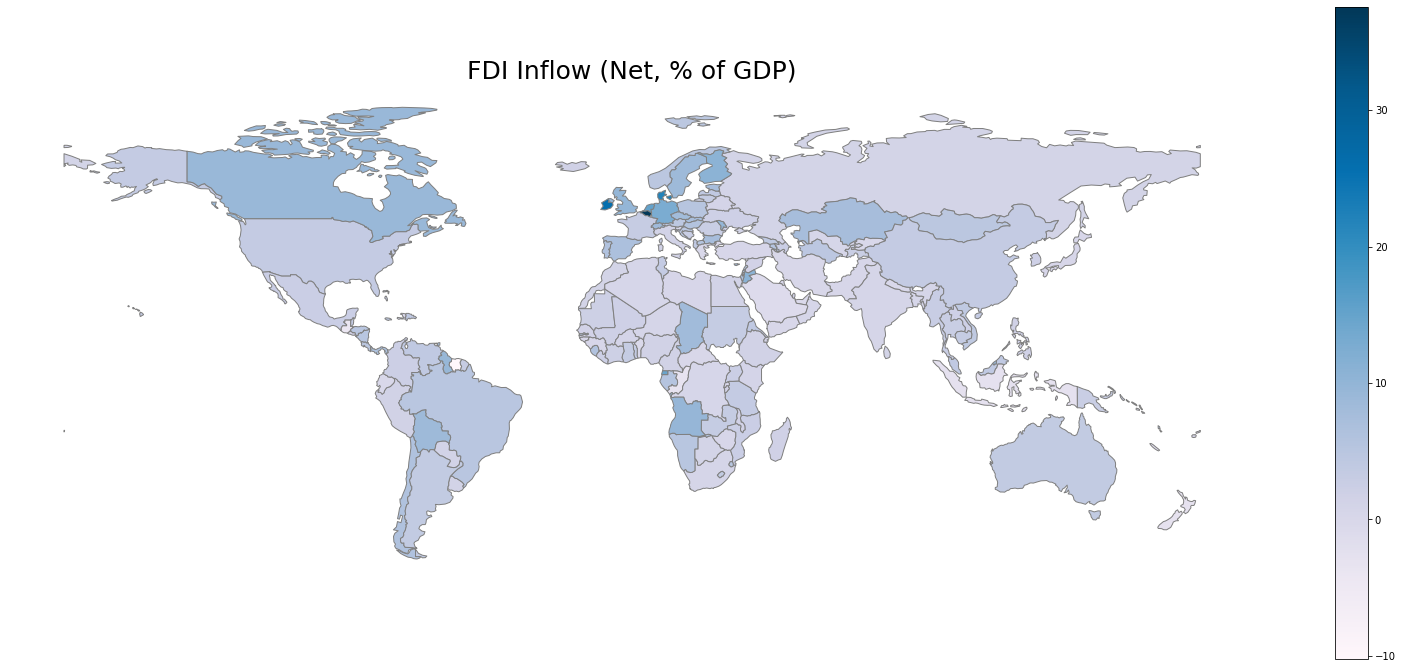

In [31]:
# set to min and max of data
vmin, vmax = min(data_mapped_filter['value']), max(data_mapped_filter['value'])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(28,12))

# add a title and annotation
ax.set_title('FDI Inflow (Net, % of GDP)', fontdict={'fontsize': '25', 'fontweight' : '3'})

data_mapped_filter.plot(column='value',cmap='PuBu', linewidth=1, ax=ax, edgecolor='.5')
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='PuBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm)

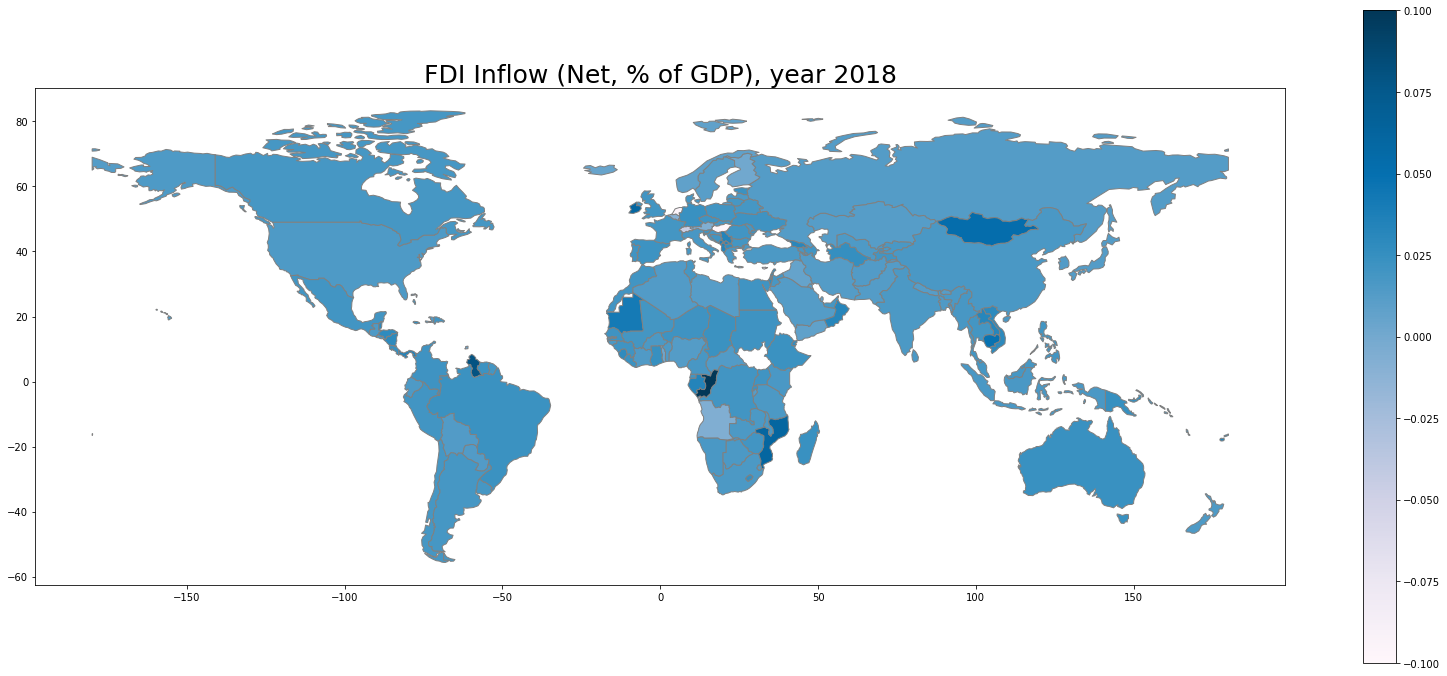

In [32]:
from matplotlib.animation import FuncAnimation
vmin, vmax = np.quantile(data_mapped['value'], 0.05), np.quantile(data_mapped['value'], 0.95)
fig, ax = plt.subplots(1, figsize=(28,12))
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='PuBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm)

def animate(i):
    ax.clear()
    data_mapped_filter = data_mapped.loc[data_mapped.loc[:,'variable'] == f'YR{i}',:]
    ax.clear()
    ax.set_title(f'FDI Inflow (Net, % of GDP), year {i}', fontdict={'fontsize': '25', 'fontweight' : '3'})
    p = data_mapped_filter.plot(column='value',cmap='PuBu', linewidth=1, ax=ax, edgecolor='.5')
    return ax
    
anim = FuncAnimation(fig, animate, frames=range(2000,2019,), interval=500, blit=False)
anim.save('fdi_gdp_flow.gif')

## Storing the data

Storing the data in the Scientific Data Warehouse (SDW) can be done via the nuvolos package, which comes already installed in every JupyterLab application.

In this particular example, we will melt the data to be in the 'long' format, then we will store the resulting pandas DataFrame object in the SDW via a simple call. As a final step, we will provide some column comments and table comments to clarify the contents for later usage.

In [33]:
FDI_GDP_PCT_data

,economy,Country,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
0,ZWE,Zimbabwe,0.346788,0.056069,0.408381,0.066346,0.149855,1.786206,0.734768,1.301978,...,1.018022,2.441511,2.044131,1.954060,2.425173,1.999687,1.669274,1.121496,3.062893,1.305924
1,ZMB,Zambia,3.379914,3.541352,7.114949,7.078975,5.851719,4.284032,4.827129,9.418112,...,8.533196,4.725162,6.789381,7.487105,5.553442,7.450178,3.163072,4.281401,1.552281,2.350807
2,YEM,"Yemen, Rep.",0.066299,1.573189,1.068780,-0.756557,1.034961,-1.803717,5.880659,4.236847,...,0.610358,-1.582339,-0.040222,-0.330496,-0.539513,-0.036383,-1.813423,-1.009308,-1.201120,-1.642892
3,PSE,West Bank and Gaza,1.437442,0.478967,0.265482,0.324395,0.445787,0.707064,0.347549,0.336950,...,1.858607,2.135156,0.515918,1.402539,1.141638,0.751036,1.924478,1.140567,1.294463,NaN
4,VIR,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,EAS,East Asia & Pacific,2.114323,1.654501,1.442558,1.470299,2.057745,1.834165,2.629108,3.233343,...,2.923171,2.844218,2.443465,2.766007,2.866894,2.818426,2.357809,2.295330,2.322509,1.852309
260,EAR,Early-demographic dividend,1.550669,1.831162,1.609926,1.217198,1.544805,2.328869,2.820506,2.992453,...,2.174632,2.018346,1.840229,2.143148,1.773522,2.197511,1.964692,1.962031,2.024287,1.996047
261,CEB,Central Europe and the Baltics,5.505023,4.615246,5.015902,3.221342,5.644932,8.433066,8.144959,12.117771,...,1.594939,3.451339,2.902613,1.076573,3.611997,1.736172,8.755489,1.981435,-1.325143,4.528846
262,CSS,Caribbean small states,4.995396,5.781831,5.770156,5.891742,5.855650,6.714152,6.735109,6.365633,...,4.010042,3.216802,0.933152,1.264857,4.131145,4.019339,4.148990,2.707834,3.717145,4.810579


In [34]:
FDI_GDP_PCT_data_melt = FDI_GDP_PCT_data.melt(id_vars = ['economy', 'Country'])

In [35]:
FDI_GDP_PCT_data_melt['variable'] = FDI_GDP_PCT_data_melt['variable'].apply(lambda x: x.replace('YR', '')).apply(lambda x: np.int_(x))

In [36]:
import nuvolos
con = nuvolos.get_connection()
con.autocommit = True

In [37]:
nuvolos.to_sql(df = FDI_GDP_PCT_data_melt, name = "FDI_GDP_PCT", con = con, if_exists='replace', index=False)

(True,
 1,
 Decimal('5280'),
 [('qznmn/file0.txt', 'LOADED', Decimal('5280'), Decimal('5280'), Decimal('1'), Decimal('0'), None, None, None, None)])

## Adding metadata

You can add table comments and column comments to provide a short description of the fields or tables of interest. While this feature cannot serve as a complete documentation solution, it will prove very useful for data used by a large number of users.

In [38]:
cur = con.cursor()
cur.execute("COMMENT ON COLUMN FDI_GDP_PCT.value IS 'Foreign Direct Investment as Pct of GDP'")
cur.execute("COMMENT ON COLUMN FDI_GDP_PCT.variable IS 'Time Period'")
cur.execute("COMMENT ON COLUMN FDI_GDP_PCT.economy IS 'ISO A3 Country Code'")
cur.commit()